In [14]:
# install machine gnostics
# recommended to run in a new virtual environment

# !pip install machinegnostics #<-- Uncomment this line to install the package

# Gnostic AutoRegressor for Time Series

### **Overview**
The **Machine Gnostics AutoRegressor (AR)** provides a robust implementation of the autoregressive model for time series forecasting, enhanced with **Gnostic Weighted Learning**. This approach automatically identifies and adapts to temporary anomalies and outliers in the historical data.

Key advantages:
- **Robustness to Outliers**: Gnostic weights down-weight anomalous time steps.
- **Iterative Refinement**: The model improves its resistance to noise over several gnostic iterations.
- **Trend Support**: Handles constant and linear trends robustly.
- **Forecasting**: Reliable multi-step forecasting even when training history is contaminated.

---

### **Theoretical Background**

The Gnostic AutoRegressor creates an AR(p) model where the coefficients are estimated using iteratively reweighted least squares, based on the **Thermodynamic Gnostic Entropy** of the residuals.

1.  **Model**: $y_t = c + \sum_{i=1}^p w_i y_{t-i} + \text{trend} + \epsilon_t$
2.  **Weighting**: Time steps with large "gnostic" residuals (unexpected jumps) are assigned lower weights.
3.  **Refinement**: The coefficients are re-estimated focusing on the "consistent" history.

***

## Example 1: Robust Forecasting

A simple example showing how to use the Gnostic AutoRegressor on a synthetic time series with artificial outliers.

Time Series Length: 150


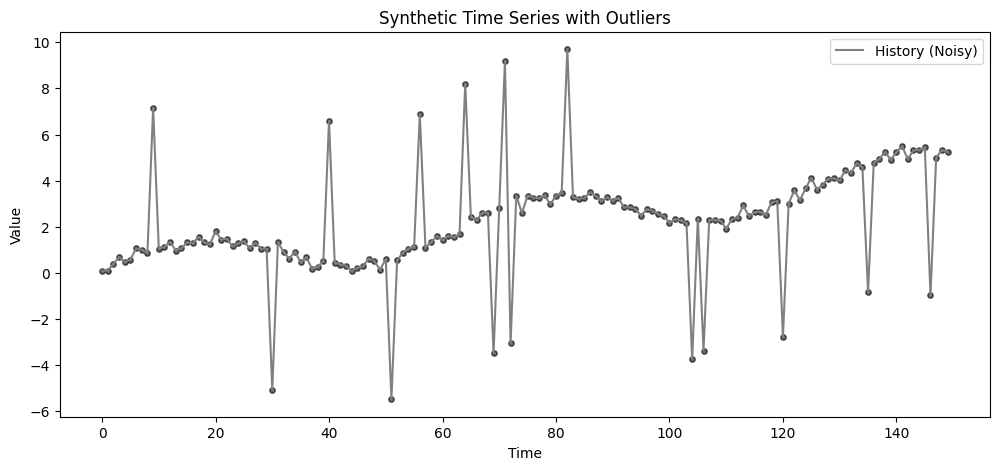

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from machinegnostics.models import AutoRegressor

# Set random seed
np.random.seed(42)

def generate_time_series(n_samples=200, trend_slope=0.03, freq=0.1, outlier_prob=0.1):
    """Generate generic time series data with outliers."""
    t = np.arange(n_samples)
    
    # Base signal: Sine wave + Linear Trend
    y = np.sin(freq * t) + trend_slope * t
    
    # Add Gaussian noise
    y += np.random.normal(0, 0.2, n_samples)
    
    # Add Outliers
    n_outliers = int(n_samples * outlier_prob)
    outlier_indices = np.random.choice(n_samples, n_outliers, replace=False)
    
    # Make outliers extreme
    y[outlier_indices] += np.random.choice([-6, 6], n_outliers)
    
    return t, y

# Generate data
t, y = generate_time_series(n_samples=150)

print(f"Time Series Length: {len(y)}")

# Visualizing the raw data
plt.figure(figsize=(12, 5))
plt.plot(t, y, color='gray', label='History (Noisy)')
plt.scatter(t, y, color='black', s=15, alpha=0.6)
plt.title("Synthetic Time Series with Outliers")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

In [16]:
# Initialize model
model = AutoRegressor(
    lags=15, 
    trend='ct',         # Constant + Trend
    max_iter=50,        # Iterations for weight convergence
    verbose=False
)

# Fit to data
print("Training Gnostic AutoRegressor...")
model.fit(y)

print(f"\nModel trained!")
print(f"Iterations run: {len(model._history) if model._history else 'N/A'}")
model.summary()

Training Gnostic AutoRegressor...

Model trained!
Iterations run: 5
Gnostic AutoRegressor (lags=15, trend='ct')
Iterations: 5
Final Weights Stats:
  Min: 0.0000
  Max: 0.0122
  Mean: 0.0074


In [17]:
# Forecast 20 steps ahead
forecast_steps = 30
forecast = model.predict(steps=forecast_steps)

# Create future time vector
t_future = np.arange(len(t), len(t) + forecast_steps)
print(f"Next 5 predicted values: {forecast[:5]}")

# Calculate Score
score = model.score(y)
print(f"Robust R2 Score: {score:.4f}")

Next 5 predicted values: [5.13061736 5.41640993 5.16088251 5.09162157 5.44788962]
Robust R2 Score: 0.2637


### Visualization: Forecast vs History
We plot the forecast in blue. Notice how it tracks the main sine wave + linear trend despite the large random spikes in the history.

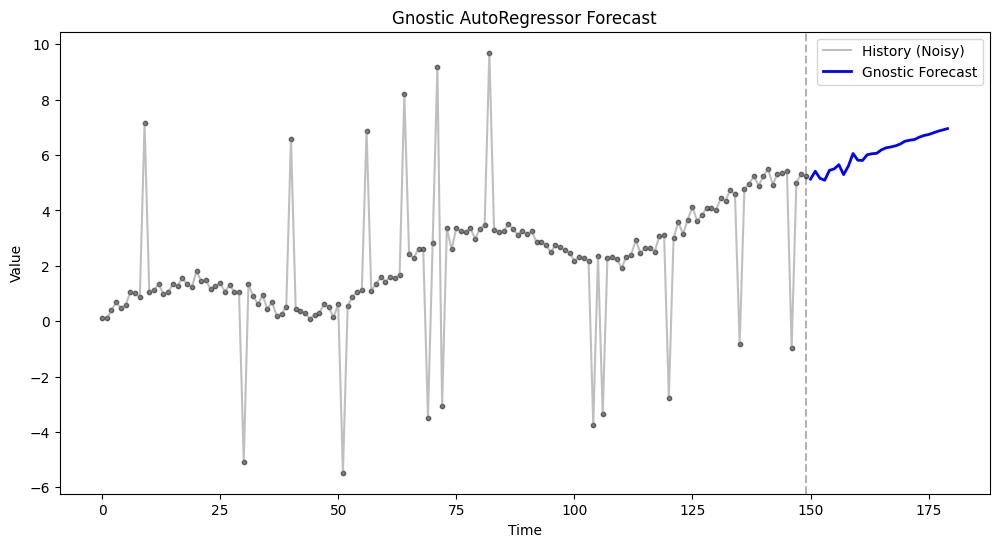

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(t, y, color='gray', alpha=0.5, label='History (Noisy)')
plt.scatter(t, y, color='black', s=10, alpha=0.5)

# Plot Forecast
plt.plot(t_future, forecast, color='blue', linewidth=2, label='Gnostic Forecast')

# Highlight the transition
plt.axvline(x=t[-1], color='k', linestyle='--', alpha=0.3)

plt.title("Gnostic AutoRegressor Forecast")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

## Example 2: Understanding Gnostic Weights

The model assigns lower weights to samples that are hard to predict (outliers/noise/anomalies). 
Here we color the time series points by their learned Gnostic Weight.
- **Yellow**: High weight (Normal)
- **Purple**: Low weight (Outlier)

Gnostic Weights Statistics:
----------------------------------------
Mean weight: 0.0074
Min weight:  0.0000
Max weight:  0.0122


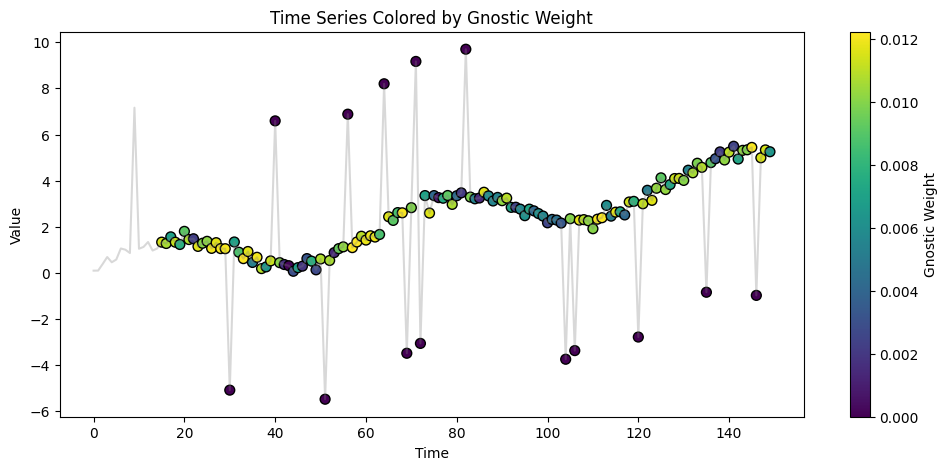

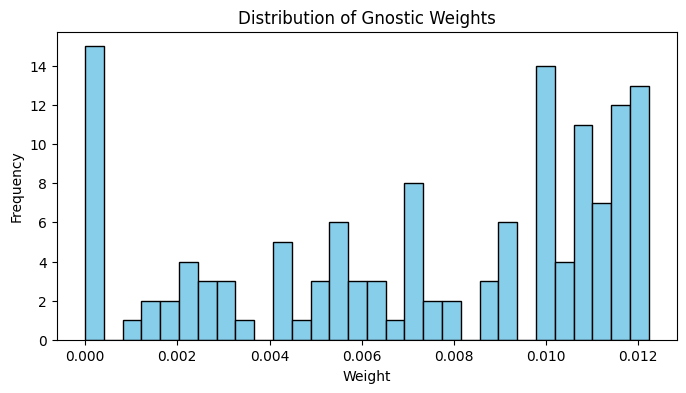

In [19]:
# Inspect Weights
# Note: weights length might be len(y) - lags. 
# The first 'lags' samples don't have predictions/weights in the training process.
weights = model.weights
valid_indices = range(model.lags, len(y))

if weights is not None and len(weights) == len(valid_indices):
    print("Gnostic Weights Statistics:")
    print("-" * 40)
    print(f"Mean weight: {np.mean(weights):.4f}")
    print(f"Min weight:  {np.min(weights):.4f}")
    print(f"Max weight:  {np.max(weights):.4f}")

    # Visualize weights on the time series
    plt.figure(figsize=(12, 5))
    plt.plot(t, y, color='gray', alpha=0.3)
    
    # Scatter plot colored by weight
    sc = plt.scatter(t[valid_indices], y[valid_indices], c=weights, cmap='viridis', s=50, edgecolors='k')
    plt.colorbar(sc, label='Gnostic Weight')
    plt.title('Time Series Colored by Gnostic Weight')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

    # Histogram
    plt.figure(figsize=(8, 4))
    plt.hist(weights, bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of Gnostic Weights')
    plt.xlabel('Weight')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("Weights not available or dimension mismatch.")

## Model History

Tracking how the Gnostic Entropy (loss) improves over iterations.

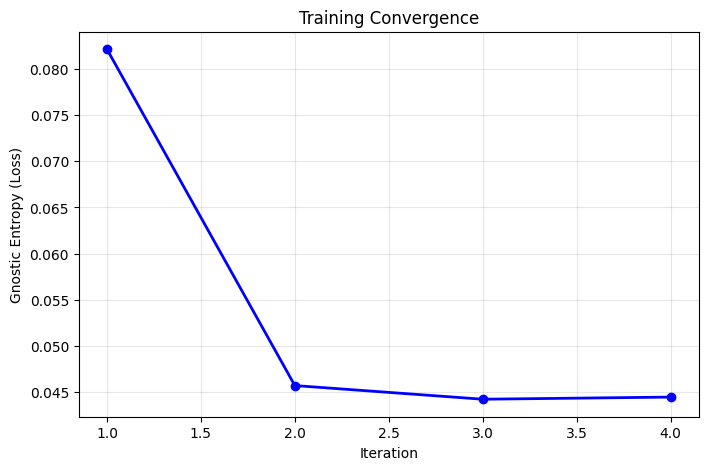

Evolution of metrics:
Iter 0: Loss = None
Iter 4: Loss = 0.04447787280394491


In [20]:
history = model._history

if len(history) > 1:
    iterations = [h['iteration'] for h in history if h['iteration'] is not None]
    
    # Extract losses if available, key might be 'h_loss' or 'rentropy' depending on base class implementation
    # AutoRegressor stores: 'h_loss', 'coefficients', 'rentropy', 'weights'
    losses = [h.get('rentropy', np.nan) for h in history if h['iteration'] is not None]
    
    plt.figure(figsize=(8, 5))
    plt.plot(iterations, losses, 'b-o', linewidth=2)
    plt.title('Training Convergence')
    plt.xlabel('Iteration')
    plt.ylabel('Gnostic Entropy (Loss)')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("Evolution of metrics:")
    for i, loss in zip(iterations, losses):
        if i % 5 == 0 or i == iterations[-1]: # Print every 5th or last
             print(f"Iter {i}: Loss = {loss}")
else:
    print("Model converged in 1 iteration or history not available.")